# UNet for CNN segmentation

In this notebook we present the most advanced example of the deep learning network that will conclude this machine learning course. We will implement a UNet architecture for segmentation of cortex in neonatal brain MRI.

### UNet architecture

<img src="images/unet.png" alt="Drawing" style="width: 500px;" align="right"/>

We will implement the UNet architecture shown on in the image on the right. The path down is called an *encoder*, as it encodes image into a latent representation features, and up path is called *decoder* because it decodes the latent representation back into an image, which in our case will be the desired segmentation.

We will start by generating a random image with size $256\times256$

In [1]:
import torch
im = torch.randint(0,255,(1,1,256,256)).float()
im.shape

torch.Size([1, 1, 256, 256])

### Encoder

The first encoder block consists of a convolutional layer with one input and 8 output channels, followed by ReLU activation. WHen we pass the image through this block we get an activation map `enc1`:

In [2]:
import torch.nn as nn
# convolution
conv1_down = nn.Conv2d(1,8,3,padding=1)
# activation
ReLU = nn.ReLU()
# pass image through the first block to obtain activation map
enc1 = ReLU(conv1_down(im))
enc1.shape

torch.Size([1, 8, 256, 256])

The second block starts with average pool to decrease spatial resolution to $128\times128$, followed by a convolutional layer and ReLU. The resulting output `enc2` has 16 channels:

In [3]:
down = nn.AvgPool2d(kernel_size=2)
conv2_down = nn.Conv2d(8,16,3,padding=1)
enc2=down(enc1)
enc2=ReLU(conv2_down(enc2))
enc2.shape

torch.Size([1, 16, 128, 128])

__Activity 1:__ Implement the third convolutional block, consisting of average pool, convolutional layer and ReLU. Check that output has size $64\times 64$ and 32 channels.

In [4]:
conv3_down = nn.Conv2d(16,32,3,padding=1)
enc3=down(enc2)
enc3=ReLU(conv3_down(enc3))
enc3.shape

torch.Size([1, 32, 64, 64])

__Activity 2:__ Implement the bottom block, that contains average pool, followed by convolutional layer and ReLU. Check that dimensions fit with the diagram.

In [5]:
conv4 = nn.Conv2d(32,32,3,padding=1)
enc4=down(enc3)
enc4=ReLU(conv4(enc4))
enc4.shape

torch.Size([1, 32, 32, 32])

### Decoder

Here we give example of the first decoder block. It consist of upsampling, followed by convolution, concatenation of activation from the encoder and ReLU:

In [6]:
up = nn.UpsamplingBilinear2d(scale_factor=2)
conv3_up = nn.Conv2d(32+32,16,3,padding=1)
dec3=up(enc4)
dec3=torch.cat([dec3, enc3], dim=1)
dec3=ReLU(conv3_up(dec3))
dec3.shape

torch.Size([1, 16, 64, 64])

__Activity 3:__ Implement second and third decoder block. Check that the final output has two channels (corresponding to binary segmentation) and the original spatial dimension $256\times 256$.

In [7]:
conv2_up = nn.Conv2d(16+16,8,3,padding=1)
dec2=up(dec3)
dec2=torch.cat([dec2, enc2], dim=1)
dec2=ReLU(conv2_up(dec2))
dec2.shape

torch.Size([1, 8, 128, 128])

In [8]:
conv1_up = nn.Conv2d(8+8,2,3,padding=1)
dec1=up(dec2)
dec1=torch.cat([dec1, enc1], dim=1)
dec1=ReLU(conv1_up(dec1))
dec1.shape

torch.Size([1, 2, 256, 256])

### Unet Architecture

We will put all this layers together in a model called `UNet`. To check that it works, we will pass our random image `im` through it and check the dimension of the output.

In [9]:
# UNet architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv1_down = nn.Conv2d(1,8,3,padding=1)
        self.conv2_down = nn.Conv2d(8,16,3,padding=1)
        self.conv3_down = nn.Conv2d(16,32,3,padding=1)
        self.conv4 = nn.Conv2d(32,32,3,padding=1)
        self.conv3_up = nn.Conv2d(32+32,16,3,padding=1)
        self.conv2_up = nn.Conv2d(16+16,8,3,padding=1)
        self.conv1_up = nn.Conv2d(8+8,2,3,padding=1)

        self.down = nn.AvgPool2d(kernel_size=2)
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        self.ReLU = nn.ReLU()

    def forward(self, x):
        #encoder
        enc1=self.ReLU(self.conv1_down(x))
        enc2=self.down(enc1)
        enc2=self.ReLU(self.conv2_down(enc2))
        enc3=self.down(enc2)
        enc3=self.ReLU(self.conv3_down(enc3))
        enc4=self.down(enc3)
        enc4=self.ReLU(self.conv4(enc4))
        #decoder
        dec3=self.up(enc4)
        dec3=torch.cat([dec3, enc3], dim=1)
        dec3=self.ReLU(self.conv3_up(dec3))
        dec2=self.up(dec3)
        dec2=torch.cat([dec2, enc2], dim=1)
        dec2=self.ReLU(self.conv2_up(dec2))
        dec1=self.up(dec2)
        dec1=torch.cat([dec1, enc1], dim=1)
        dec1=self.ReLU(self.conv1_up(dec1))

        return dec1
    
# create an instance of the network
net=UNet()
# pass image through the network
o=net(im)
# check the dimension of th output
o.shape

torch.Size([1, 2, 256, 256])

### Neonatal dataset

The neonatal dataset is available in a zip file. The code below unpacks it into a new folder `mridata` on your disk.

In [10]:
from zipfile import ZipFile
with ZipFile('datasets/mridata.zip', 'r') as zipObj:
    zipObj.extractall()

In [11]:
# If using google colab uncoment this code and run this cell instead

# from google.colab import files
# files.upload() # upload mridata.zip

# from zipfile import ZipFile
# with ZipFile('mridata.zip', 'r') as zipObj:
#     zipObj.extractall()

Dataset consist of 395 brain MRI images with the segmentations. To view an example image and segmentation, run the cell. To extract cortical label from the label image, we apply thresholding, because the edges between invidividual labels have been blurred when images were stored in jpeg format. Change `i` to visualise different subjects.

Text(0.5, 1.0, 'Cortex')

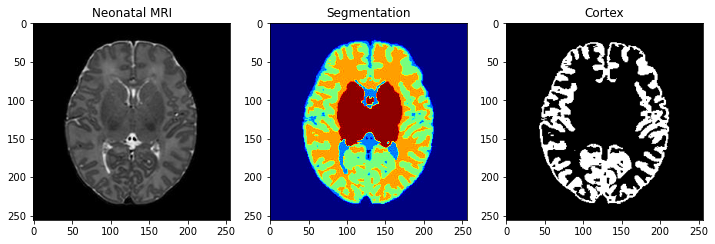

In [12]:
import matplotlib.pyplot as plt
import numpy as np

i = 100
image_name = "mridata/{}_t2w.jpg".format(i)
im = plt.imread(image_name)
label_name = "mridata/{}_lab.jpg".format(i)
lab = plt.imread(label_name)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(im,cmap='gray')
plt.title('Neonatal MRI')
plt.subplot(132)
plt.imshow(lab, cmap='jet')
plt.title('Segmentation')
plt.subplot(133)
cortex = np.logical_and(lab>=100,lab<=150)
plt.imshow(cortex,cmap='gray')
plt.title('Cortex')

### Datasets and dataloaders

You can see that unlike previously, our dataset is stored on the disk, rather than being loaded into memory all at once. We can still access it, but will need to create a `Dataset` and a `DataLoader` class to do that for us.

In the cell below we implemented the `Dataset` class. It 
* splits the dataset into train, validation, and test sets during initialisation `__init__`
* returns the number of items in each set using `__len__`
* implements accessing a single datapoint from the disk in `__getitem__` and converting it to required format for training

In [13]:
from torch.utils.data import Dataset
import numpy as np

class NeonatalDataset(Dataset):

    def __init__(self, set_type='train'):
        # split dataset into train/val/test
        nTrain=320
        nVal=32
        nTest=44
        if set_type=='train':
            self.start_idx=0
            self.len=nTrain
        if set_type=='val':
            self.start_idx=nTrain
            self.len=nVal
        if set_type=='test':
            self.start_idx=nTrain+nVal
            self.len=nTest

    def __len__(self):
        # return length of the dataset
        return self.len

    def __getitem__(self, idx):
        # load MR image
        image_name="mridata/{}_t2w.jpg".format(idx)
        image=plt.imread(image_name)
        image=image/255
        # load label
        label_name="mridata/{}_lab.jpg".format(idx)
        labels=plt.imread(label_name)
        cortex=np.logical_and(labels>=100,labels<=150)
        # convert to tensor float and shape 1x256x256
        image=torch.Tensor(image).float().unsqueeze(0)
        # convert to tensor long and shape 256x256
        cortex=torch.Tensor(cortex).long()
        # return prepared data
        data=[image, cortex]
        return data

The training, validation and test dataset are then created as follows:

In [14]:
data_train = NeonatalDataset('train')
data_val = NeonatalDataset('val')
data_test = NeonatalDataset('test')

The datasets can be manipulated through `DataLoader` class. In this example we choose to create batches of 16 images for training:

In [15]:
from torch.utils.data import DataLoader
data_train_loader=DataLoader(data_train,batch_size=16)
data_val_loader=DataLoader(data_val,batch_size=16)
data_test_loader=DataLoader(data_test,batch_size=16)

__Activity 4:__ The code below shows how we can loop through the batches of a validation set. Run the cell to see the result. Then amend the cell to look at training and test sets as well. How many batches are in each?

In [16]:
for i, (data, labels) in enumerate(data_val_loader):
    print(i)
    print(data.shape)
    print(labels.shape)

0
torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256])
1
torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256])


### Training UNet

Training UNet is not any different from training of the CNN classifier we have seen in the previous example. However we will need to incorporate the dataloaders this time.

__Activity 5:__ Create the instance of a `UNet` network and cross-entropy loss. Send them to GPU. You have done that previously.

In [17]:
# Set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")
else: device = torch.device("cpu")
print(device)

# Create network and loss
net = UNet().to(device)
loss = nn.CrossEntropyLoss().to(device)

cuda


This time we will use Adam optimiser because it performs better for this task:

In [18]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.005)

__Activity 6:__ Complete the training loop. Note that it contains loop not only over epochs but also over batches. Run the training and be patient, it may take a little while for the network to converge.

In [19]:
epochs = 50
train_losses=[]
val_losses=[]

for epoch in range(epochs):

    # training mode
    net.train()

    # to collect loss over the batches
    mean_ce = 0.0
    # loop over training batches
    for i, (data, label) in enumerate(data_train_loader):
        # send training data to GPU
        data = data.to(device)
        labels = label.to(device)
        # training
        optimizer.zero_grad()
        pred = net(data)
        ce = loss(pred, labels)
        ce.backward()
        optimizer.step()
        # add loss
        mean_ce += ce.item()

    # save training loss
    # divided by number of batches
    mean_ce /= 20
    train_losses.append(mean_ce)

    # validation mode
    with torch.no_grad():
        net.eval()

        # to collect loss over the batches
        mean_ce_val=0.0
        # loop over validation batches
        for i, (data, label) in enumerate(data_val_loader):
            # send validation data to GPU
            data_val = data.to(device)
            labels_val = label.to(device)
            # calculate validation loss
            pred_val = net(data_val)
            ce_val = loss(pred_val, labels_val)
            # add validation loss
            mean_ce_val += ce_val.item()

        # save validation loss
        # divided by number of batches
        mean_ce_val /= 2
        val_losses.append(mean_ce_val)

    # Print loss every 10 epochs
    if epoch % 10==0:
        s='Epoch: {}, Train loss: {:.4f}, Val Loss: {:.4f}'
        print(s.format(epoch, mean_ce, mean_ce_val))


Epoch: 0, Train loss: 0.4487, Val Loss: 0.3177
Epoch: 10, Train loss: 0.1143, Val Loss: 0.1056
Epoch: 20, Train loss: 0.0864, Val Loss: 0.0819
Epoch: 30, Train loss: 0.0787, Val Loss: 0.0732
Epoch: 40, Train loss: 0.0747, Val Loss: 0.0698


We can now plot the training and validation losses over epochs:

Text(0, 0.5, 'CE loss')

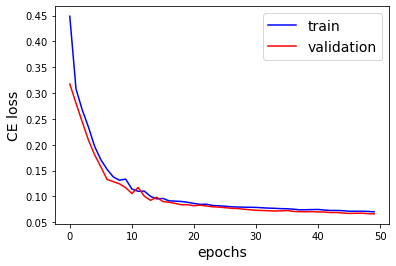

In [20]:
plt.plot(train_losses,'b',label='train')
plt.plot(val_losses,'r',label='validation')
plt.legend(fontsize=14)
plt.xlabel('epochs',fontsize=14)
plt.ylabel('CE loss',fontsize=14)

### Evaluation

The code below compares the ground truth segmentation and predicted segmentation of the first subject from each batch.

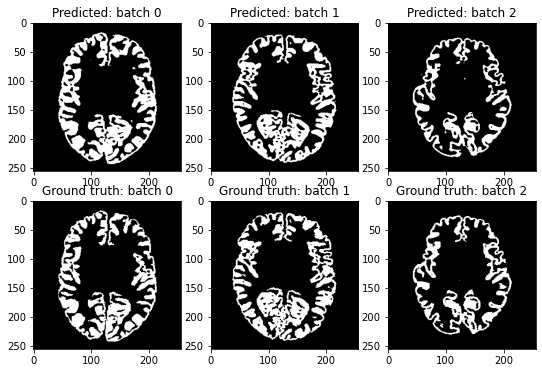

In [21]:
plt.figure(figsize=(9,6))
for i, (data, labels) in enumerate(data_test_loader):
    # predict the labels
    data = data.to(device)
    pred = net(data).detach().cpu()
    l_pred = torch.argmax(pred, dim=1)
    # plot first subject from each batch
    plt.subplot(2,3,i+1)
    plt.title('Predicted: batch {}'.format(i))
    plt.imshow(l_pred[0,:,:],cmap='gray')
    plt.subplot(2,3,i+1+3)
    plt.title('Ground truth: batch {}'.format(i))
    plt.imshow(labels[0,:,:],cmap='gray')

It works! Well done, you have trained your first UNet!

One last thing - let's calculate quantitative performance on the test set.

In [22]:
from sklearn.metrics import f1_score, \
    precision_score, recall_score

# scores to calculate
f1_scores=[]
prec_scores=[]
recall_scores=[]

# loop over batches
for i, (data, labels) in enumerate(data_test_loader):
    # predict the labels
    data = data.to(device)
    pred = net(data).detach().cpu()
    l_pred = torch.argmax(pred, dim=1)
    #loop over images in the batch
    for j in range(pred.shape[0]):
        # flatten to vectors
        y=labels[j,:,:].flatten()
        y_pred=l_pred[j,:,:].flatten()
        # calculate and save scores
        f1_scores.append(f1_score(y,y_pred))
        prec_scores.append(precision_score(y,y_pred))
        recall_scores.append(recall_score(y,y_pred))

# print out scores averaged over test images
print('f1 score:',round(np.mean(f1_scores),2))
print('precision:',round(np.mean(prec_scores),2))
print('recall:',round(np.mean(recall_scores),2))

f1 score: 0.91
precision: 0.91
recall: 0.91


*And we are done!*